# scaling the model and analyze the coefficients and residuals.


- training a model with scaled data, i going to scale the data with a standarScaler()

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import pandas as pd


In [3]:
data = pd.read_csv("../data/processed/StudentsPerformance_processed.csv")
data.head()

,gender,parental level of education,math score,reading score,writing score,lunch_standard,test preparation course_none,race/ethnicity_group A,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E
0,1,4,72,72,74,True,True,False,True,False,False,False
1,1,2,69,90,88,True,False,False,False,True,False,False
2,1,5,90,95,93,True,True,False,True,False,False,False
3,0,3,47,57,44,False,True,True,False,False,False,False
4,0,2,76,78,75,True,True,False,False,True,False,False


- select the columns to scale (no booleans) and scale the data
we can´t to scale the math score because is the target, and it doen´t have a big values (not necessary)

- also put the target at the end of the data

In [4]:
X = data.drop(columns = ['math score'])
y = data['math score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaled_columns = ['parental level of education', 'reading score', 'writing score']
bool_columns = [c for c in X.columns if c not in scaled_columns]

scaler = StandardScaler()
X_train_scaled_columns = scaler.fit_transform(X_train[scaled_columns])

X_train_scaled = pd.concat([pd.DataFrame(X_train_scaled_columns, columns=scaled_columns),
                        X_train[bool_columns].reset_index(drop=True)], axis=1)

X_test_scaled_columns = scaler.fit_transform(X_test[scaled_columns])
X_test_scaled = pd.concat([pd.DataFrame(X_test_scaled_columns, columns=scaled_columns),
                        X_test[bool_columns].reset_index(drop=True)], axis=1)



- training the scaled_model

In [5]:
scaled_model = LinearRegression()
scaled_model.fit(X_train_scaled, y_train)
y_pred = scaled_model.predict(X_test_scaled)
r2_scaled_01 = r2_score(y_test, y_pred)
print("R^2: ", r2_scaled_01)

R^2:  0.8628641247089452


In [6]:
import joblib
route = '../models/scaled_model.pkl'
joblib.dump(scaled_model, route)
model_test = joblib.load(route)
print("test prediction:", model_test.predict(X_test_scaled[:2]))

test prediction: [77.73267043 60.0055076 ]


analyze the coefficients

In [10]:
coefficients_DF = pd.DataFrame({
    'variables':  X_train_scaled.columns,
    'coefficients': scaled_model.coef_
}).sort_values(by='coefficients', ascending=False)

print(coefficients_DF)
print(f"B_0: {scaled_model.intercept_}")

                       variables  coefficients
2                  writing score     10.946755
10        race/ethnicity_group E      4.116733
4                 lunch_standard      3.534778
1                  reading score      3.370908
5   test preparation course_none      3.313586
7         race/ethnicity_group B     -0.455204
0    parental level of education     -0.620743
6         race/ethnicity_group A     -0.846152
8         race/ethnicity_group C     -1.397844
9         race/ethnicity_group D     -1.417533
3                         gender    -13.095750
B_0: 69.29439332721046


In [17]:
import numpy as np
coefficients_DF['impact'] = np.abs(coefficients_DF['coefficients'])
coefficients_DF = coefficients_DF.sort_values(by='impact', ascending=False)
print(coefficients_DF)

                       variables  coefficients     impact
3                         gender    -13.095750  13.095750
2                  writing score     10.946755  10.946755
10        race/ethnicity_group E      4.116733   4.116733
4                 lunch_standard      3.534778   3.534778
1                  reading score      3.370908   3.370908
5   test preparation course_none      3.313586   3.313586
9         race/ethnicity_group D     -1.417533   1.417533
8         race/ethnicity_group C     -1.397844   1.397844
6         race/ethnicity_group A     -0.846152   0.846152
0    parental level of education     -0.620743   0.620743
7         race/ethnicity_group B     -0.455204   0.455204


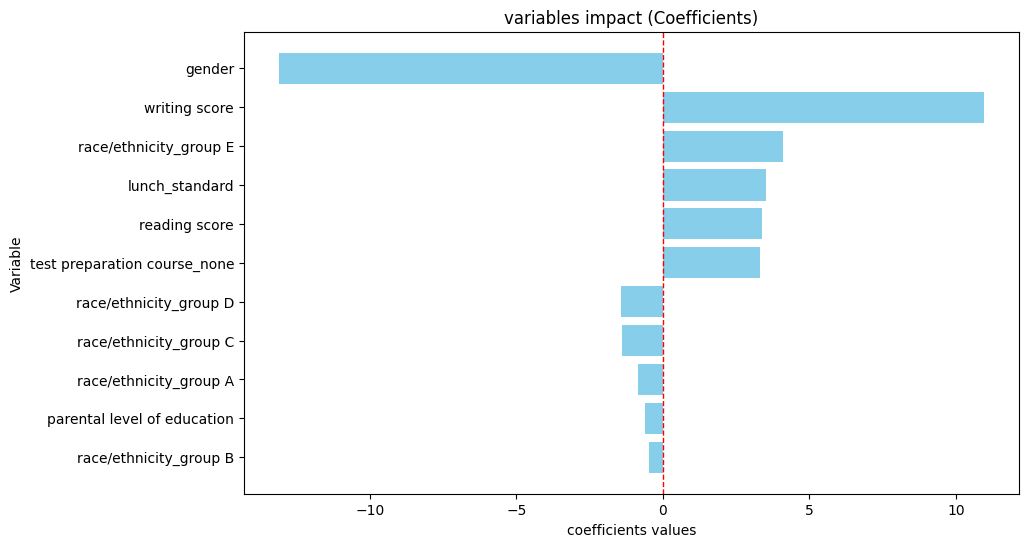

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
bars = plt.barh(coefficients_DF['variables'], coefficients_DF['coefficients'], color='skyblue')
plt.xlabel('coefficients values')
plt.ylabel('Variable')
plt.title('variables impact (Coefficients)')
plt.gca().invert_yaxis()
plt.axvline(0, color='red', linestyle='--', linewidth=1)  
plt.savefig("../images/coefficients.png", dpi=300, bbox_inches='tight')
plt.show()